In [1]:
# Results

import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle


class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, params):

        angle = params['rotation_range'][0]
        angle = (random.uniform(0,1))*random.choice([-1,1])*angle
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = rotate_transform(np.array(image), angle = angle, mode = 'edge')

        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8))

    def translation(self, image,  params):
        image_shape = np.array(image).shape
        ty = random.uniform(params['height_shift_range'][0]*image_shape[0],          
                            params['height_shift_range'][1]*image_shape[0])
        tx = random.uniform(params['width_shift_range'][0]*image_shape[1],
                            params['width_shift_range'][1]*image_shape[1] )

        
        horizontal_shift =  tx*random.choice([-1,1])
        vertical_shift = ty*random.choice([-1,1])
        horizontal_shift_normalised = horizontal_shift/image_shape[1]
        vertical_shift_normalised =  vertical_shift/image_shape[0]

        transform = AffineTransform(translation=(-horizontal_shift,-vertical_shift))

        image = warp(np.array(image),transform,mode='edge')


  
        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8))
        
    def resize(self, image, img_size):
        image = TF.resize(image, img_size)
        return image

    def zoom(self, image, params):

        img_shape = np.array(image).shape
        zoom = random.uniform(params['zoom_range'][0],params['zoom_range'][1])
        image = TF.resize(image,(int(img_shape[0]*zoom), int(img_shape[1]*zoom)) )
        scale_transform = torch.tensor([[zoom, 0], 
                                        [0, zoom]])

        
        return image

    def color_jitter(self, image):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image


    def __call__(self, image, params, image_size):

        # set checked image and landmark to landmark_ and image_ (this is for making sure we use the last checked tranformed instead of wrongly tranformed to do the following               # tranform)
        
        # -----------------------
        image_ = Image.fromarray(image.copy())

        # -----------------------

        # ZOOM
        image  = self.zoom(image_,  params)
        

        # RESIZE

        image = self.resize(image, (image_size, image_size))

        # ----------------------
        #image_, landmarks_ = self.color_jitter(image_, landmarks_)
        # ----------------------
        
        # ROTATE
        image = self.rotate(image,  params)


        # ----------------------

        image = image
        # ----------------------

        # TRANSLATION
        image= self.translation(image, params)

 
        
        image = TF.to_tensor(image)
        # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
        image = TF.normalize(image, [0.5], [0.5])
        return image

class LandmarksDataset():

    def __init__(self, transform=None,zoom = [1.0 - 0.03258157476873315, 1.0 + 0.03258157476873315], rotation = [22], height_shift= [0,0.03003200603616672], width_shift= [0,0.03003200603616672 ]):

        # targets 0
        filenames1 = os.listdir('D:/Tsetse fly Project/Data/Missing_landmarkwings_L/')
        #filenames2 = os.listdir('D:/Tsetse fly Project/Data/Missing_landmarkwings_R/')
        # targets 1
        filenames3 = os.listdir('C:/Users/dylan/Desktop/goodwingsv20-21/')
    
        self. tranform = transform
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
        self.image_filenames = []
        self.targets = []
        self.image_size = 244
        self.transform = transform
        self.image_dir = 'D:/Tsetse fly Project/Data/Missing_landmarkwings_L/'
        
        #self.image_dir2 = 'D:/Tsetse fly Project/Data/Missing_landmarkwings_R/'
        self.image_dir3 = 'C:/Users/dylan/Desktop/goodwingsv20-21/'
        self.TransF_ = True

       # ------------------- Append left wings data to dataset class ------------

        for filename in filenames1:
            self.image_filenames.append(os.path.join(self.image_dir, filename))
            self.targets.append(1)

            

        # ------------------ Append flipped right wings data to dataset class-----


        #for filename in filenames2[:]:
        #    self.targets.append(1)
        #    self.image_filenames.append(os.path.join(self.image_dir2, filename))

        #num = len(self.targets.copy())
        for filename in filenames3:
            self.targets.append(0)
            self.image_filenames.append(os.path.join(self.image_dir3, filename))



        # ----------------------

    def TransF(self):
        self.TransF_ = True
    def NoTransF(self):
        self.TransF_ = False
    def resize(self,size):
        self.image_size = size
    def set_params(self, zoom = [0.95, 0.105], rotation = [10], height_shift= [0,0.05], width_shift= [0,0.05]):
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        params = {'zoom_range': self.zoom, 'rotation_range':self.rotation, 'height_shift_range': self.height_shift, 'width_shift_range': self.width_shift }
        image_ = plt.imread(self.image_filenames[index])
        target = torch.tensor(self.targets[index])

        image = plt.imread(self.image_filenames[index])

        
        if self.transform and self.TransF_:
            
            image = self.transform(image_, params, self.image_size)

        else:
            img_shape = image.copy().shape
            image = Image.fromarray(image)
            image = TF.resize(image, (self.image_size,self.image_size))
       
            image = TF.to_tensor(image)
            # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
            image = TF.normalize(image, [0.5], [0.5])

        return image, target #self.image_filenames[index]

DataSet = LandmarksDataset(Transforms())


In [2]:
# Load models

class vgg16_bn_(nn.Module):
    def __init__(self,num_classes=1):
        super().__init__()
        self.model_name='vgg16_bn'
        self.model=models.vgg16_bn(pretrained=True)
        #self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.classifier=nn.Linear(self.model.classifier[0].in_features, num_classes)
        
    def forward(self, x):
        x = torch.sigmoid(self.model(x))
        return x

class resnet18_(nn.Module):
    def __init__(self,num_classes=1):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained = True)
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=torch.sigmoid(self.model(x))
        return x

class inception_(nn.Module):
    def __init__(self,num_classes=1):
        super().__init__()
        self.model_name='inception'
        self.model=models.inception_v3(pretrained=True)
        self.model.Conv2d_1a_3x3.conv=nn.Conv2d(3, 32, kernel_size=3, stride=2,  bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        self.model.AuxLogits.fc = nn.Linear(self.model.AuxLogits.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        if self.model.training:
        
            x = torch.sigmoid(x.logits)
        else:
            
            x = torch.sigmoid(x)
        return x


In [3]:
# load test set
# split data for image size 244

DataSet.NoTransF()
DataSet.resize(244)
dataset = DataSet
# split the dataset into validation and test sets
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=15, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,batch_sampler=None, shuffle=False)


The length of Train set is 842
The length of Valid set is 280
The length of Valid set is 280


In [8]:
images, targets = test_dataset[0]
print(images)
images = images.reshape((1,3,244,244))
images.shape

tensor([[[ 0.2392,  0.2235,  0.2314,  ...,  0.2471,  0.2314,  0.2314],
         [ 0.2549,  0.2392,  0.2235,  ...,  0.2471,  0.2314,  0.2392],
         [ 0.2000,  0.2235,  0.2235,  ...,  0.2392,  0.2392,  0.2471],
         ...,
         [ 0.1216,  0.1373,  0.1608,  ...,  0.0275,  0.0196, -0.0196],
         [ 0.1294,  0.1451,  0.1686,  ...,  0.0196, -0.0039, -0.0196],
         [ 0.1451,  0.1608,  0.1686,  ...,  0.0039, -0.0196, -0.0431]],

        [[ 0.2863,  0.2706,  0.2706,  ...,  0.3098,  0.3020,  0.3020],
         [ 0.2549,  0.2706,  0.2627,  ...,  0.3098,  0.2941,  0.2941],
         [ 0.2471,  0.2627,  0.2471,  ...,  0.2941,  0.2784,  0.2941],
         ...,
         [ 0.0980,  0.1216,  0.1373,  ...,  0.0431,  0.0353,  0.0118],
         [ 0.0980,  0.1294,  0.1451,  ...,  0.0431,  0.0275,  0.0039],
         [ 0.1294,  0.1529,  0.1608,  ...,  0.0353,  0.0118, -0.0275]],

        [[ 0.5294,  0.5843,  0.5529,  ...,  0.3804,  0.3725,  0.3333],
         [ 0.4980,  0.4980,  0.5137,  ...,  0

torch.Size([1, 3, 244, 244])

In [4]:
#vgg16


import random
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
#Load vgg16_bn and make prediction on test set

vgg16 = vgg16_bn_()
vgg16.load_state_dict(torch.load('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/classifiers/models/model_vgg16_bn_classifer_finetune.pth'))
vgg16.cpu()
vgg16.eval()


# make predictions on test set

bootstrap_size = 5000
spec = []
sense = []
f1 = []
prec = []
acc = []

start_time = time.time()
y_pred_vgg16 = np.array([])
y_truth_vgg16 = np.array([])

start_time = time.time()

for images, targets in test_dataset:
    images = images.reshape((1,3,244,244))
    y = vgg16(images)
    
    y = y.detach().flatten().numpy()
    y_pred_vgg16 = np.append(y_pred_vgg16, y)
    y_truth_vgg16 = np.append(y_truth_vgg16, targets.detach().flatten().numpy())
endtime = time.time()-start_time
print('time taken to make predictions on test set',endtime)    
print('bootstrap size', len(y_pred_vgg16))
vggpred = []
for i in y_pred_vgg16:
    if i<0.5:
        vggpred.append(0)
    else:
        vggpred.append(1)

# bootstrap predictions (205 per sample)
bootstrap_samples = []
for i in range(bootstrap_size):
    samples_truth = []
    samples_pred = []
    for s in range(205):
        index_range = np.arange(len(vggpred))
        index = random.choice(index_range)
        sample_pred = vggpred[index]
        sample_truth = y_truth_vgg16[index]
        samples_truth.append(sample_truth)
        samples_pred.append(sample_pred)
    tn, fp, fn, tp = confusion_matrix(samples_truth, samples_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp/ (tp+fn)
    f1score = f1_score(samples_truth, samples_pred)
    precision = precision_score(samples_truth, samples_pred)
    accuracy = accuracy_score(samples_truth, samples_pred)
    spec.append(specificity)
    sense.append(sensitivity)
    f1.append(f1score)
    prec.append(precision)
    acc.append(accuracy)
bootstrap_samples.append([spec, sense, prec, f1, acc])



bootstrap_samples = np.array(bootstrap_samples).reshape((5,5000))
spec = np.sort(bootstrap_samples[0, :])
sense = np.sort(bootstrap_samples[1, :])
prec = np.sort(bootstrap_samples[2, :])
f1 = np.sort(bootstrap_samples[3, :])
acc = np.sort(bootstrap_samples[4, :])

spec_lowerbound = np.percentile(spec, 2.5)
spec_upperbound = np.percentile(spec, 97.5)
sense_lowerbound = np.percentile(sense, 2.5)
sense_upperbound = np.percentile(sense, 97.5)
prec_lowerbound = np.percentile(prec, 2.5)
prec_upperbound = np.percentile(prec, 97.5)
f1_lowerbound = np.percentile(f1, 2.5)
f1_upperbound = np.percentile(f1, 97.5)
acc_lowerbound = np.percentile(acc, 2.5)
acc_upperbound = np.percentile(acc, 97.5)


tn, fp, fn, tp = confusion_matrix(y_truth_vgg16,vggpred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp/ (tp+fn)
f1score = f1_score(samples_truth, samples_pred)
precision = precision_score(samples_truth, samples_pred)
accuracy = accuracy_score(samples_truth, samples_pred)



results = pd.DataFrame([[spec_lowerbound, sense_lowerbound,prec_lowerbound,f1_lowerbound, acc_lowerbound  ],
                        [specificity, sensitivity, precision, f1score, accuracy],
                        [spec_upperbound, sense_upperbound,prec_upperbound,f1_upperbound, acc_upperbound  ]], columns = ['Specificity', 'Sensitivity', 'Precision', 'f1_score', 'Accuracy'], index = ['Lower bound', 'Value','Upper bound'])
results

time taken to make predictions on test set 152.7725043296814
bootstrap size 280


,Specificity,Sensitivity,Precision,f1_score,Accuracy
Lower bound,1.0,1.0,1.0,1.0,1.0
Value,1.0,1.0,1.0,1.0,1.0
Upper bound,1.0,1.0,1.0,1.0,1.0


In [6]:
#resnet18

import random
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
#Load resnet18_bn and make prediction on test set

resnet18 = resnet18_()
resnet18.load_state_dict(torch.load('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/classifiers/models/model_resnet18_classifer_finetune.pth'))
resnet18.cpu()
resnet18.eval()


# make predictions on test set

bootstrap_size = 5000
spec = []
sense = []
f1 = []
prec = []
acc = []

start_time = time.time()
y_pred_resnet18 = np.array([])
y_truth_resnet18 = np.array([])

start_time = time.time()

for images, targets in test_dataset:
    images = images.reshape((1,3,244,244))
    y = resnet18(images)
    
    y = y.detach().flatten().numpy()
    y_pred_resnet18 = np.append(y_pred_resnet18, y)
    y_truth_resnet18 = np.append(y_truth_resnet18, targets.detach().flatten().numpy())
endtime = time.time()-start_time
print('time taken to make predictions on test set',endtime)    
print('bootstrap size', len(y_pred_resnet18))
resnetpred = []
for i in y_pred_resnet18:
    if i<0.5:
        resnetpred.append(0)
    else:
        resnetpred.append(1)

# bootstrap predictions (205 per sample)
bootstrap_samples = []
for i in range(bootstrap_size):
    samples_truth = []
    samples_pred = []
    for s in range(205):
        index_range = np.arange(len(resnetpred))
        index = random.choice(index_range)
        sample_pred = resnetpred[index]
        sample_truth = y_truth_resnet18[index]
        samples_truth.append(sample_truth)
        samples_pred.append(sample_pred)
    tn, fp, fn, tp = confusion_matrix(samples_truth, samples_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp/ (tp+fn)
    f1score = f1_score(samples_truth, samples_pred)
    precision = precision_score(samples_truth, samples_pred)
    accuracy = accuracy_score(samples_truth, samples_pred)
    spec.append(specificity)
    sense.append(sensitivity)
    f1.append(f1score)
    prec.append(precision)
    acc.append(accuracy)
bootstrap_samples.append([spec, sense, prec, f1, acc])



bootstrap_samples = np.array(bootstrap_samples).reshape((5,5000))
spec = np.sort(bootstrap_samples[0, :])
sense = np.sort(bootstrap_samples[1, :])
prec = np.sort(bootstrap_samples[2, :])
f1 = np.sort(bootstrap_samples[3, :])
acc = np.sort(bootstrap_samples[4, :])

spec_lowerbound = np.percentile(spec, 2.5)
spec_upperbound = np.percentile(spec, 97.5)
sense_lowerbound = np.percentile(sense, 2.5)
sense_upperbound = np.percentile(sense, 97.5)
prec_lowerbound = np.percentile(prec, 2.5)
prec_upperbound = np.percentile(prec, 97.5)
f1_lowerbound = np.percentile(f1, 2.5)
f1_upperbound = np.percentile(f1, 97.5)
acc_lowerbound = np.percentile(acc, 2.5)
acc_upperbound = np.percentile(acc, 97.5)


tn, fp, fn, tp = confusion_matrix(y_truth_resnet18,resnetpred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp/ (tp+fn)
f1score = f1_score(samples_truth, samples_pred)
precision = precision_score(samples_truth, samples_pred)
accuracy = accuracy_score(samples_truth, samples_pred)



results = pd.DataFrame([[spec_lowerbound, sense_lowerbound,prec_lowerbound,f1_lowerbound, acc_lowerbound  ],
                        [specificity, sensitivity, precision, f1score, accuracy],
                        [spec_upperbound, sense_upperbound,prec_upperbound,f1_upperbound, acc_upperbound  ]], columns = ['Specificity', 'Sensitivity', 'Precision', 'f1_score', 'Accuracy'], index = ['Lower bound', 'Value','Upper bound'])
results


time taken to make predictions on test set 66.68074536323547
bootstrap size 280


,Specificity,Sensitivity,Precision,f1_score,Accuracy
Lower bound,1.0,0.971698,1.0,0.985646,0.985366
Value,1.0,0.993007,1.0,0.991304,0.990244
Upper bound,1.0,1.000000,1.0,1.000000,1.000000


In [7]:
#inception

import random
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
#Load inception_bn and make prediction on test set

inception = inception_()
inception.load_state_dict(torch.load('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/classifiers/models/model_inception_classifer_finetune.pth'))
inception.cpu()
inception.eval()


# make predictions on test set

bootstrap_size = 5000
spec = []
sense = []
f1 = []
prec = []
acc = []

start_time = time.time()
y_pred_inception = np.array([])
y_truth_inception = np.array([])

start_time = time.time()

for images, targets in test_dataset:
    images = images.reshape((1,3,244,244))
    y = inception(images)
    
    y = y.detach().flatten().numpy()
    y_pred_inception = np.append(y_pred_inception, y)
    y_truth_inception = np.append(y_truth_inception, targets.detach().flatten().numpy())
endtime = time.time()-start_time
print('time taken to make predictions on test set',endtime)    
print('bootstrap size', len(y_pred_inception))
inceptionpred = []
for i in y_pred_inception:
    if i<0.5:
        inceptionpred.append(0)
    else:
        inceptionpred.append(1)

# bootstrap predictions (205 per sample)
bootstrap_samples = []
for i in range(bootstrap_size):
    samples_truth = []
    samples_pred = []
    for s in range(205):
        index_range = np.arange(len(inceptionpred))
        index = random.choice(index_range)
        sample_pred = inceptionpred[index]
        sample_truth = y_truth_inception[index]
        samples_truth.append(sample_truth)
        samples_pred.append(sample_pred)
    tn, fp, fn, tp = confusion_matrix(samples_truth, samples_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp/ (tp+fn)
    f1score = f1_score(samples_truth, samples_pred)
    precision = precision_score(samples_truth, samples_pred)
    accuracy = accuracy_score(samples_truth, samples_pred)
    spec.append(specificity)
    sense.append(sensitivity)
    f1.append(f1score)
    prec.append(precision)
    acc.append(accuracy)
bootstrap_samples.append([spec, sense, prec, f1, acc])



bootstrap_samples = np.array(bootstrap_samples).reshape((5,5000))
spec = np.sort(bootstrap_samples[0, :])
sense = np.sort(bootstrap_samples[1, :])
prec = np.sort(bootstrap_samples[2, :])
f1 = np.sort(bootstrap_samples[3, :])
acc = np.sort(bootstrap_samples[4, :])

spec_lowerbound = np.percentile(spec, 2.5)
spec_upperbound = np.percentile(spec, 97.5)
sense_lowerbound = np.percentile(sense, 2.5)
sense_upperbound = np.percentile(sense, 97.5)
prec_lowerbound = np.percentile(prec, 2.5)
prec_upperbound = np.percentile(prec, 97.5)
f1_lowerbound = np.percentile(f1, 2.5)
f1_upperbound = np.percentile(f1, 97.5)
acc_lowerbound = np.percentile(acc, 2.5)
acc_upperbound = np.percentile(acc, 97.5)

tn, fp, fn, tp = confusion_matrix(y_truth_inception,inceptionpred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp/ (tp+fn)
f1score = f1_score(samples_truth, samples_pred)
precision = precision_score(samples_truth, samples_pred)
accuracy = accuracy_score(samples_truth, samples_pred)



results = pd.DataFrame([[spec_lowerbound, sense_lowerbound,prec_lowerbound,f1_lowerbound, acc_lowerbound  ],
                        [specificity, sensitivity, precision, f1score, accuracy],
                        [spec_upperbound, sense_upperbound,prec_upperbound,f1_upperbound, acc_upperbound  ]], columns = ['Specificity', 'Sensitivity', 'Precision', 'f1_score', 'Accuracy'], index = ['Lower bound', 'Value','Upper bound'])
results


time taken to make predictions on test set 76.56764602661133
bootstrap size 280


,Specificity,Sensitivity,Precision,f1_score,Accuracy
Lower bound,0.957447,1.0,0.961165,0.980198,0.980488
Value,0.985401,1.0,0.980392,0.990099,0.990244
Upper bound,1.000000,1.0,1.000000,1.000000,1.000000


In [25]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

x = np.random.randint(40, 400, 100).reshape(-1, 1)
y = np.random.randint(0, 2, 100)

model = LogisticRegression()
model.fit(x, y)
probs = model.predict_proba(x)
fpr, tpr, thresholds = metrics.roc_curve(y_truth_inception, y_pred_inception)

# %%
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 28
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="lower right")
plt.title('Inception')
plt.xlabel("FPR")
plt.ylabel("TPR")

NameError: name 'y_truth_inception' is not defined

Text(0, 0.5, 'TPR')

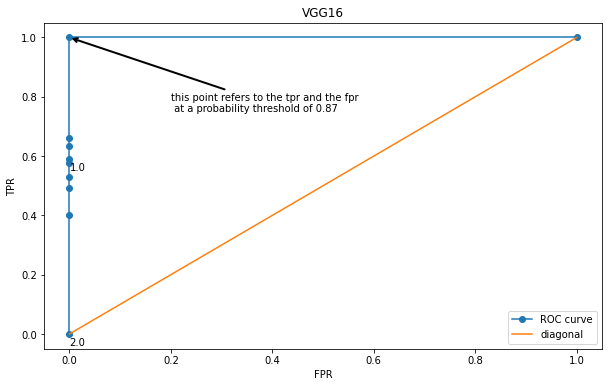

In [27]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


x = np.random.randint(40, 400, 100).reshape(-1, 1)
y = np.random.randint(0, 2, 100)

#model = LogisticRegression()
#model.fit(x, y)
#probs = model.predict_proba(x)
fpr, tpr, thresholds = metrics.roc_curve(y_truth_vgg16, y_pred_vgg16)

# %%
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 8
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="lower right")
plt.title('VGG16')
plt.xlabel("FPR")
plt.ylabel("TPR")

(array([101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 141.]),
 array([3.43591128e-10, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

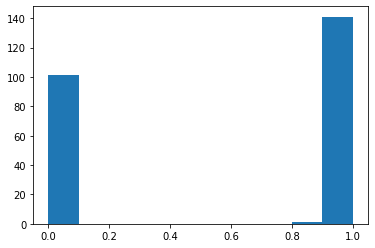

In [31]:
hh = np.sort(y_pred_vgg16)
plt.hist(hh)

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_truth_vgg16, vggpred)
row_sums = cm.sum(axis=1)
new_matrix = cm / row_sums[:, np.newaxis]
display(new_matrix)


array([[1., 0.],
       [0., 1.]])

Text(0, 0.5, 'TPR')

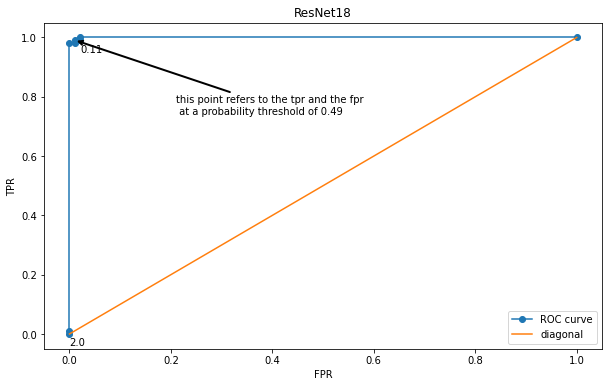

In [71]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

x = np.random.randint(40, 400, 100).reshape(-1, 1)
y = np.random.randint(0, 2, 100)

model = LogisticRegression()
model.fit(x, y)
probs = model.predict_proba(x)
fpr, tpr, thresholds = metrics.roc_curve(y_truth_resnet18, y_pred_resnet18)

# %%
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 4
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="lower right")
plt.title('ResNet18')
plt.xlabel("FPR")
plt.ylabel("TPR")

inception
[1.99999964e+00 9.99999642e-01 9.99998689e-01 9.99998569e-01
 9.99998331e-01 9.99997973e-01 9.99997258e-01 9.99997020e-01
 9.99996781e-01 9.99996543e-01 9.99995828e-01 9.99995708e-01
 9.99994397e-01 9.99994278e-01 9.99994159e-01 9.99994040e-01
 9.99991655e-01 9.99991179e-01 9.99991059e-01 9.99990940e-01
 9.99990106e-01 9.99989152e-01 9.99988079e-01 9.99987841e-01
 9.99986053e-01 9.99985695e-01 9.99982595e-01 9.99982357e-01
 8.55871662e-02 7.93824995e-07]


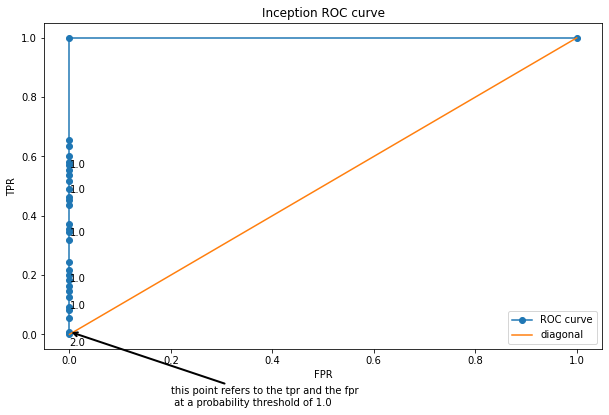

In [51]:
print('inception')

import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


fpr, tpr, thresholds = metrics.roc_curve(y_truth_inception, y_pred_inception)
# %%
print(thresholds)
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 1
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="lower right")
plt.title('Inception ROC curve')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig('inceproc.png')